In [15]:
import pandas as pd
import itertools
import pickle
import numpy as np
import os
import random
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings("ignore")

In [5]:
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def random_combinations(elements):
    n = len(elements)
    size1 = n // 3
    size2 = n // 3
    
    list1 = elements[:size1]
    list2 = elements[size1:size1 + size2]
    list3 = elements[size1 + size2:]

    setup_seed(42)
    list1 = random.sample(list1, 400)
    list2 = random.sample(list2, 400)
    list3 = random.sample(list3, 400)

    all_combinations = sorted(list(itertools.product(list1, list2, list3)))
    
    return all_combinations

In [6]:
# read datasets
db = pd.read_csv('PCorr_TPI_datasets/hu.MAP3.0_complexes_wConfidenceScores_total15326_wGenenames_20240922.csv')
db.index = db['HuMAP3_ID']

# CRISPR/RNAi
ge_matrix = pickle.load(open('../general_datasets/ge_matrix.pkl', 'rb'))

# CRISPR和RNAi分别的所有gene
genes_all_key = {}
genes_all_key['CRISPR'] = list(ge_matrix['CRISPR'].columns)
genes_all_key['RNAi'] = list(ge_matrix['RNAi'].columns)

# ge_cut
ge_cut = {}
ge_cut['CRISPR'] = -0.237
ge_cut['RNAi'] = -0.325

seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_TPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_RanNeg_seed_key = pickle.load(open('PCorr_TPI_datasets/ft_RanNeg_seed_key.pkl', 'rb'))
ft_DecoyNeg_seed_key = pickle.load(open('PCorr_TPI_datasets/ft_DecoyNeg_seed_key.pkl', 'rb'))

##### 1. Constructing TPI sets 

In [7]:
# TPIs derived from huMAP3
subunit_id = {}
for i in db.index:
    subunits = set(db.loc[i,'genenames'].split(' '))
    subunit_id[i] = subunits

tpis_humap = set()
tpi_id = {}
id_tpi = {}
conf_id = {}
for i in tqdm(subunit_id.keys()):
    subunits = subunit_id[i]
    conf_id[i] = db.loc[i,'ComplexConfidence']
    if len(subunits) >= 3:
        tpis = set()
        combinations = list(itertools.combinations(subunits, 3))
        for c in combinations:
            t = sorted(list(c))
            tpi = (t[0],t[1],t[2])
            tpis.add(tpi)
            tpis_humap.add(tpi)
            try:
                id_tpi[tpi].add(i)
            except:
                id_tpi[tpi] = set()
                id_tpi[tpi].add(i)
        tpi_id[i] = tpis

100%|██████████| 15326/15326 [00:24<00:00, 636.84it/s]


In [ ]:
# random TPIs
ids_random = random_combinations(sorted(list(db.index)))

tpis_random = set()
for i in tqdm(ids_random):
    i_ = sorted(list(i))
    subunits_1 = sorted(list(subunit_id[i_[0]]))
    subunits_2 = sorted(list(subunit_id[i_[1]]))
    subunits_3 = sorted(list(subunit_id[i_[2]]))

    setup_seed(42)
    g1 = random.choice(subunits_1)
    setup_seed(42)
    g2 = random.choice(subunits_2)
    setup_seed(42)
    g3 = random.choice(subunits_3)

    if g1 != g2 and g1 != g3 and g2 != g3:
        tpi = tuple(sorted([g1,g2,g3]))
        if tpi not in tpis_humap:
            tpis_random.add(tpi)
tpis_random = tuple(sorted(list(tpis_random)))

##### 2. PCorr signals of huMAP3-derived TPIs

In [ ]:
# Extraction of feature matrices
ft_humap_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    triangles_list = []
    ft_all_list = []
    for triangle in tqdm(tpis_humap):
        pros = sorted(list(triangle))
        g1 = pros[0]
        g2 = pros[1]
        g3 = pros[2]

        genes_all = genes_all_key[ge_key]
        if g1 in genes_all and g2 in genes_all and g3 in genes_all:
            ge_1 = ge_matrix[ge_key][g1].dropna()
            ge_2 = ge_matrix[ge_key][g2].dropna()
            ge_3 = ge_matrix[ge_key][g3].dropna()

            ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
            ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]
            ge_f_3 = ge_3[ge_3 < ge_cut[ge_key]]

            ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index) & set(ge_f_3.index))

            ge_final_1 = ge_f_1[ccls_inter]
            ge_final_2 = ge_f_2[ccls_inter]
            ge_final_3 = ge_f_3[ccls_inter]

            if len(ccls_inter) >= 5:
                # pearson相关性系数
                pearson_r_gg12 = pearsonr(ge_final_1, ge_final_2)
                pearson_r_gg23 = pearsonr(ge_final_2, ge_final_3)
                pearson_r_gg13 = pearsonr(ge_final_1, ge_final_3)

                pearson_corr_gg12 = pearson_r_gg12[0]
                pearson_corr_gg23 = pearson_r_gg23[0]
                pearson_corr_gg13 = pearson_r_gg13[0]

                pearson_p_gg12 = pearson_r_gg12[1]
                pearson_p_gg23 = pearson_r_gg23[1]
                pearson_p_gg13 = pearson_r_gg13[1]

                # ols模型
                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_2, X_with_intercept)
                ols_r_gg12 = model_ols.fit()

                X_with_intercept = sm.add_constant(ge_final_2)
                model_ols = sm.OLS(ge_final_3, X_with_intercept)
                ols_r_gg23 = model_ols.fit()

                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_3, X_with_intercept)
                ols_r_gg13 = model_ols.fit()

                ols_coeff_0_gg12 = ols_r_gg12.params[0]
                ols_se_0_gg12 = ols_r_gg12.bse[0]
                ols_coeff_1_gg12 = ols_r_gg12.params[1]
                ols_se_1_gg12 = ols_r_gg12.bse[1]

                ols_coeff_0_gg23 = ols_r_gg23.params[0]
                ols_se_0_gg23 = ols_r_gg23.bse[0]
                ols_coeff_1_gg23 = ols_r_gg23.params[1]
                ols_se_1_gg23 = ols_r_gg23.bse[1]

                ols_coeff_0_gg13 = ols_r_gg13.params[0]
                ols_se_0_gg13 = ols_r_gg13.bse[0]
                ols_coeff_1_gg13 = ols_r_gg13.params[1]
                ols_se_1_gg13 = ols_r_gg13.bse[1]

                g1_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_1]))
                g2_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_2]))
                g3_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_3]))

                g1_mean = np.mean(ge_final_1)
                g2_mean = np.mean(ge_final_2)
                g3_mean = np.mean(ge_final_3)

                g1_std = np.std(ge_final_1)
                g2_std = np.std(ge_final_2)
                g3_std = np.std(ge_final_3)

                g1_min = min(ge_final_1)
                g1_25 = np.percentile(ge_final_1, 25)
                g1_50 = np.percentile(ge_final_1, 50)
                g1_75 = np.percentile(ge_final_1, 75)
                g1_max = max(ge_final_1)

                g2_min = min(ge_final_2)
                g2_25 = np.percentile(ge_final_2, 25)
                g2_50 = np.percentile(ge_final_2, 50)
                g2_75 = np.percentile(ge_final_2, 75)
                g2_max = max(ge_final_2)

                g3_min = min(ge_final_3)
                g3_25 = np.percentile(ge_final_3, 25)
                g3_50 = np.percentile(ge_final_3, 50)
                g3_75 = np.percentile(ge_final_3, 75)
                g3_max = max(ge_final_3)

                ge_e_1 = []
                for k in ge_1:
                    if k > 0:
                        ge_e_1.append(0)
                    else:
                        ge_e_1.append(k)

                ge_e_2 = []
                for k in ge_2:
                    if k > 0:
                        ge_e_2.append(0)
                    else:
                        ge_e_2.append(k)

                ge_e_3 = []
                for k in ge_3:
                    if k > 0:
                        ge_e_3.append(0)
                    else:
                        ge_e_3.append(k)

                g1_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_1]))
                g2_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_2]))
                g3_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_3]))

                g1_mean_all = np.mean(ge_e_1)
                g2_mean_all = np.mean(ge_e_2)
                g3_mean_all = np.mean(ge_e_3)

                g1_std_all = np.std(ge_e_1)
                g2_std_all = np.std(ge_e_2)
                g3_std_all = np.std(ge_e_3)

                g1_min_all = min(ge_e_1)
                g1_25_all = np.percentile(ge_e_1, 25)
                g1_50_all = np.percentile(ge_e_1, 50)
                g1_75_all = np.percentile(ge_e_1, 75)
                g1_max_all = max(ge_e_1)

                g2_min_all = min(ge_e_2)
                g2_25_all = np.percentile(ge_e_2, 25)
                g2_50_all = np.percentile(ge_e_2, 50)
                g2_75_all = np.percentile(ge_e_2, 75)
                g2_max_all = max(ge_e_2)

                g3_min_all = min(ge_e_3)
                g3_25_all = np.percentile(ge_e_3, 25)
                g3_50_all = np.percentile(ge_e_3, 50)
                g3_75_all = np.percentile(ge_e_3, 75)
                g3_max_all = max(ge_e_3)

                features = [len(ccls_inter), pearson_corr_gg12, pearson_corr_gg23, pearson_corr_gg13,
                            pearson_p_gg12, pearson_p_gg23, pearson_p_gg13,
                            ols_coeff_0_gg12, ols_coeff_0_gg23, ols_coeff_0_gg13,
                            ols_coeff_1_gg12, ols_coeff_1_gg23, ols_coeff_1_gg13,
                            ols_se_0_gg12, ols_se_0_gg23, ols_se_0_gg13,
                            ols_se_1_gg12, ols_se_1_gg23, ols_se_1_gg13,
                            g1_essen, g2_essen, g3_essen,
                            g1_essen_all, g2_essen_all, g3_essen_all,
                            g1_mean, g2_mean, g3_mean, g1_std, g2_std, g3_std,
                            g1_25, g1_50, g1_75, g2_25, g2_50, g2_75, g3_25, g3_50, g3_75,
                            g1_min, g2_min, g3_min, g1_max, g2_max, g3_max,
                            g1_mean_all, g2_mean_all, g3_mean_all, g1_std_all, g2_std_all, g3_std_all,
                            g1_25_all, g1_50_all, g1_75_all, g2_25_all, g2_50_all, g2_75_all, g3_25_all, g3_50_all,
                            g3_75_all,
                            g1_min_all, g2_min_all, g3_min_all, g1_max_all, g2_max_all, g3_max_all,
                            ]
                triangles_list.append(triangle)
                ft_all_list.append(features)

    ft_humap_key[ge_key] = pd.DataFrame(ft_all_list, index=triangles_list,
                                        columns=['SCCLs_number', 'pearson_corr_gg12', 'pearson_corr_gg23',
                                                 'pearson_corr_gg13',
                                                 'pearson_p_gg12', 'pearson_p_gg23', 'pearson_p_gg13',
                                                 'ols_coeff_0_gg12', 'ols_coeff_0_gg23', 'ols_coeff_0_gg13',
                                                 'ols_coeff_1_gg12', 'ols_coeff_1_gg23', 'ols_coeff_1_gg13',
                                                 'ols_se_0_gg12', 'ols_se_0_gg23', 'ols_se_0_gg13',
                                                 'ols_se_1_gg12', 'ols_se_1_gg23', 'ols_se_1_gg13',
                                                 'g1_essen', 'g2_essen', 'g3_essen',
                                                 'g1_essen_all', 'g2_essen_all', 'g3_essen_all',
                                                 'g1_mean', 'g2_mean', 'g3_mean', 'g1_std', 'g2_std',
                                                 'g3_std',
                                                 'g1_25', 'g1_50', 'g1_75', 'g2_25', 'g2_50', 'g2_75',
                                                 'g3_25',
                                                 'g3_50',
                                                 'g3_75',
                                                 'g1_min', 'g2_min', 'g3_min', 'g1_max', 'g2_max', 'g3_max',
                                                 'g1_mean_all', 'g2_mean_all', 'g3_mean_all', 'g1_std_all',
                                                 'g2_std_all',
                                                 'g3_std_all',
                                                 'g1_25_all', 'g1_50_all', 'g1_75_all', 'g2_25_all',
                                                 'g2_50_all',
                                                 'g2_75_all',
                                                 'g3_25_all', 'g3_50_all', 'g3_75_all',
                                                 'g1_min_all', 'g2_min_all', 'g3_min_all',
                                                 'g1_max_all', 'g2_max_all', 'g3_max_all',
                                                 ])

# PCorr-PPI scores of huMAP3-derived TPIs
r_humap_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    r = pd.DataFrame()
    ft = ft_humap_key[ge_key]
    
    X_data = np.array(ft, dtype='float32')

    r_ = pd.DataFrame()
    r_.index = list(ft.index)

    ft_posi_seed = ft_posi_seed_key[ge_key]

    # model_1
    ft_nega_1_seed = ft_RanNeg_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)

        ft_nega_1 = ft_nega_1_seed[s]
        ft_nega_1['label'] = [0] * len(ft_nega_1)

        ft_seed_1 = pd.concat([ft_posi, ft_nega_1], axis=0)


        X = np.array(ft_seed_1.iloc[:,:-1],dtype='float32')
        y = np.array(ft_seed_1.iloc[:, [-1]],dtype='float32')
        X_train,X_temp,y_train,y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
        X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

        if ge_key == 'CRISPR':
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=10, min_samples_leaf=5)
        else:
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=7, min_samples_leaf=4)

        rf.fit(X_train, y_train)

        y_probs = rf.predict_proba(X_data)[:, 1]
        r_['y_probs_1_{}'.format(s)] = y_probs
    r_['y_probs_1'] = np.mean(r_[['y_probs_1_{}'.format(s) for s in seeds]], axis=1)

    # model_2
    ft_nega_2_seed = ft_DecoyNeg_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)

        ft_nega_2 = ft_nega_2_seed[s]
        ft_nega_2['label'] = [0] * len(ft_nega_2)

        ft_seed_2 = pd.concat([ft_posi, ft_nega_2], axis=0)


        X = np.array(ft_seed_2.iloc[:,:-1],dtype='float32')
        y = np.array(ft_seed_2.iloc[:, [-1]],dtype='float32')
        X_train,X_temp,y_train,y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
        X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

        if ge_key == 'CRISPR':
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=9, min_samples_leaf=4)
        else:
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=8, min_samples_leaf=4)

        rf.fit(X_train, y_train)

        y_probs = rf.predict_proba(X_data)[:, 1]
        r_['y_probs_2_{}'.format(s)] = y_probs
    r_['y_probs_2'] = np.mean(r_[['y_probs_2_{}'.format(s) for s in seeds]], axis=1)

    r = r_[['y_probs_1','y_probs_2']]
    r_humap_key[ge_key] = r

##### 3. PCorr signals of random TPIs

In [ ]:
# Extraction of feature matrices
ft_randomhumap_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    triangles_list = []
    ft_all_list = []
    for triangle in tqdm(tpis_random):
        pros = sorted(list(triangle))
        g1 = pros[0]
        g2 = pros[1]
        g3 = pros[2]

        genes_all = genes_all_key[ge_key]
        if g1 in genes_all and g2 in genes_all and g3 in genes_all:
            ge_1 = ge_matrix_dict[ge_key][g1].dropna()
            ge_2 = ge_matrix_dict[ge_key][g2].dropna()
            ge_3 = ge_matrix_dict[ge_key][g3].dropna()

            ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
            ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]
            ge_f_3 = ge_3[ge_3 < ge_cut[ge_key]]

            ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index) & set(ge_f_3.index))

            ge_final_1 = ge_f_1[ccls_inter]
            ge_final_2 = ge_f_2[ccls_inter]
            ge_final_3 = ge_f_3[ccls_inter]

            if len(ccls_inter) >= 5:
                # pearson相关性系数
                pearson_r_gg12 = pearsonr(ge_final_1, ge_final_2)
                pearson_r_gg23 = pearsonr(ge_final_2, ge_final_3)
                pearson_r_gg13 = pearsonr(ge_final_1, ge_final_3)

                pearson_corr_gg12 = pearson_r_gg12[0]
                pearson_corr_gg23 = pearson_r_gg23[0]
                pearson_corr_gg13 = pearson_r_gg13[0]

                pearson_p_gg12 = pearson_r_gg12[1]
                pearson_p_gg23 = pearson_r_gg23[1]
                pearson_p_gg13 = pearson_r_gg13[1]

                # ols模型
                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_2, X_with_intercept)
                ols_r_gg12 = model_ols.fit()

                X_with_intercept = sm.add_constant(ge_final_2)
                model_ols = sm.OLS(ge_final_3, X_with_intercept)
                ols_r_gg23 = model_ols.fit()

                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_3, X_with_intercept)
                ols_r_gg13 = model_ols.fit()

                ols_coeff_0_gg12 = ols_r_gg12.params[0]
                ols_se_0_gg12 = ols_r_gg12.bse[0]
                ols_coeff_1_gg12 = ols_r_gg12.params[1]
                ols_se_1_gg12 = ols_r_gg12.bse[1]

                ols_coeff_0_gg23 = ols_r_gg23.params[0]
                ols_se_0_gg23 = ols_r_gg23.bse[0]
                ols_coeff_1_gg23 = ols_r_gg23.params[1]
                ols_se_1_gg23 = ols_r_gg23.bse[1]

                ols_coeff_0_gg13 = ols_r_gg13.params[0]
                ols_se_0_gg13 = ols_r_gg13.bse[0]
                ols_coeff_1_gg13 = ols_r_gg13.params[1]
                ols_se_1_gg13 = ols_r_gg13.bse[1]

                g1_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_1]))
                g2_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_2]))
                g3_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_3]))

                g1_mean = np.mean(ge_final_1)
                g2_mean = np.mean(ge_final_2)
                g3_mean = np.mean(ge_final_3)

                g1_std = np.std(ge_final_1)
                g2_std = np.std(ge_final_2)
                g3_std = np.std(ge_final_3)

                g1_min = min(ge_final_1)
                g1_25 = np.percentile(ge_final_1, 25)
                g1_50 = np.percentile(ge_final_1, 50)
                g1_75 = np.percentile(ge_final_1, 75)
                g1_max = max(ge_final_1)

                g2_min = min(ge_final_2)
                g2_25 = np.percentile(ge_final_2, 25)
                g2_50 = np.percentile(ge_final_2, 50)
                g2_75 = np.percentile(ge_final_2, 75)
                g2_max = max(ge_final_2)

                g3_min = min(ge_final_3)
                g3_25 = np.percentile(ge_final_3, 25)
                g3_50 = np.percentile(ge_final_3, 50)
                g3_75 = np.percentile(ge_final_3, 75)
                g3_max = max(ge_final_3)

                ge_e_1 = []
                for k in ge_1:
                    if k > 0:
                        ge_e_1.append(0)
                    else:
                        ge_e_1.append(k)

                ge_e_2 = []
                for k in ge_2:
                    if k > 0:
                        ge_e_2.append(0)
                    else:
                        ge_e_2.append(k)

                ge_e_3 = []
                for k in ge_3:
                    if k > 0:
                        ge_e_3.append(0)
                    else:
                        ge_e_3.append(k)

                g1_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_1]))
                g2_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_2]))
                g3_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_3]))

                g1_mean_all = np.mean(ge_e_1)
                g2_mean_all = np.mean(ge_e_2)
                g3_mean_all = np.mean(ge_e_3)

                g1_std_all = np.std(ge_e_1)
                g2_std_all = np.std(ge_e_2)
                g3_std_all = np.std(ge_e_3)

                g1_min_all = min(ge_e_1)
                g1_25_all = np.percentile(ge_e_1, 25)
                g1_50_all = np.percentile(ge_e_1, 50)
                g1_75_all = np.percentile(ge_e_1, 75)
                g1_max_all = max(ge_e_1)

                g2_min_all = min(ge_e_2)
                g2_25_all = np.percentile(ge_e_2, 25)
                g2_50_all = np.percentile(ge_e_2, 50)
                g2_75_all = np.percentile(ge_e_2, 75)
                g2_max_all = max(ge_e_2)

                g3_min_all = min(ge_e_3)
                g3_25_all = np.percentile(ge_e_3, 25)
                g3_50_all = np.percentile(ge_e_3, 50)
                g3_75_all = np.percentile(ge_e_3, 75)
                g3_max_all = max(ge_e_3)

                features = [len(ccls_inter), pearson_corr_gg12, pearson_corr_gg23, pearson_corr_gg13,
                            pearson_p_gg12, pearson_p_gg23, pearson_p_gg13,
                            ols_coeff_0_gg12, ols_coeff_0_gg23, ols_coeff_0_gg13,
                            ols_coeff_1_gg12, ols_coeff_1_gg23, ols_coeff_1_gg13,
                            ols_se_0_gg12, ols_se_0_gg23, ols_se_0_gg13,
                            ols_se_1_gg12, ols_se_1_gg23, ols_se_1_gg13,
                            g1_essen, g2_essen, g3_essen,
                            g1_essen_all, g2_essen_all, g3_essen_all,
                            g1_mean, g2_mean, g3_mean, g1_std, g2_std, g3_std,
                            g1_25, g1_50, g1_75, g2_25, g2_50, g2_75, g3_25, g3_50, g3_75,
                            g1_min, g2_min, g3_min, g1_max, g2_max, g3_max,
                            g1_mean_all, g2_mean_all, g3_mean_all, g1_std_all, g2_std_all, g3_std_all,
                            g1_25_all, g1_50_all, g1_75_all, g2_25_all, g2_50_all, g2_75_all, g3_25_all, g3_50_all,
                            g3_75_all,
                            g1_min_all, g2_min_all, g3_min_all, g1_max_all, g2_max_all, g3_max_all,
                            ]
                triangles_list.append(triangle)
                ft_all_list.append(features)

                if len(ft_all_list) == len(ft_humap_key[ge_key]):
                    print(len(ft_all_list))
                    break

    ft_randomhumap_key[ge_key] = pd.DataFrame(ft_all_list, index=triangles_list,
                                              columns=['SCCLs_number', 'pearson_corr_gg12', 'pearson_corr_gg23',
                                                       'pearson_corr_gg13',
                                                       'pearson_p_gg12', 'pearson_p_gg23', 'pearson_p_gg13',
                                                       'ols_coeff_0_gg12', 'ols_coeff_0_gg23', 'ols_coeff_0_gg13',
                                                       'ols_coeff_1_gg12', 'ols_coeff_1_gg23', 'ols_coeff_1_gg13',
                                                       'ols_se_0_gg12', 'ols_se_0_gg23', 'ols_se_0_gg13',
                                                       'ols_se_1_gg12', 'ols_se_1_gg23', 'ols_se_1_gg13',
                                                       'g1_essen', 'g2_essen', 'g3_essen',
                                                       'g1_essen_all', 'g2_essen_all', 'g3_essen_all',
                                                       'g1_mean', 'g2_mean', 'g3_mean', 'g1_std', 'g2_std',
                                                       'g3_std',
                                                       'g1_25', 'g1_50', 'g1_75', 'g2_25', 'g2_50', 'g2_75',
                                                       'g3_25',
                                                       'g3_50',
                                                       'g3_75',
                                                       'g1_min', 'g2_min', 'g3_min', 'g1_max', 'g2_max', 'g3_max',
                                                       'g1_mean_all', 'g2_mean_all', 'g3_mean_all', 'g1_std_all',
                                                       'g2_std_all',
                                                       'g3_std_all',
                                                       'g1_25_all', 'g1_50_all', 'g1_75_all', 'g2_25_all',
                                                       'g2_50_all',
                                                       'g2_75_all',
                                                       'g3_25_all', 'g3_50_all', 'g3_75_all',
                                                       'g1_min_all', 'g2_min_all', 'g3_min_all',
                                                       'g1_max_all', 'g2_max_all', 'g3_max_all',
                                                       ])

# PCorr-PPI scores of random TPIs
r_randomhumap_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    r = pd.DataFrame()
    ft = ft_randomhumap_key[ge_key]

    X_data = np.array(ft, dtype='float32')

    r_ = pd.DataFrame()
    r_.index = list(ft.index)

    ft_posi_seed = ft_posi_seed_key[ge_key]

    # model_1
    ft_nega_1_seed = ft_RanNeg_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)

        ft_nega_1 = ft_nega_1_seed[s]
        ft_nega_1['label'] = [0] * len(ft_nega_1)

        ft_seed_1 = pd.concat([ft_posi, ft_nega_1], axis=0)


        X = np.array(ft_seed_1.iloc[:,:-1],dtype='float32')
        y = np.array(ft_seed_1.iloc[:, [-1]],dtype='float32')
        X_train,X_temp,y_train,y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
        X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

        if ge_key == 'CRISPR':
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=10, min_samples_leaf=5)
        else:
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=7, min_samples_leaf=4)

        rf.fit(X_train, y_train)

        y_probs = rf.predict_proba(X_data)[:, 1]
        r_['y_probs_1_{}'.format(s)] = y_probs
    r_['y_probs_1'] = np.mean(r_[['y_probs_1_{}'.format(s) for s in seeds]], axis=1)

    # model_2
    ft_nega_2_seed = ft_DecoyNeg_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)

        ft_nega_2 = ft_nega_2_seed[s]
        ft_nega_2['label'] = [0] * len(ft_nega_2)

        ft_seed_2 = pd.concat([ft_posi, ft_nega_2], axis=0)


        X = np.array(ft_seed_2.iloc[:,:-1],dtype='float32')
        y = np.array(ft_seed_2.iloc[:, [-1]],dtype='float32')
        X_train,X_temp,y_train,y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
        X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

        if ge_key == 'CRISPR':
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=9, min_samples_leaf=4)
        else:
            rf = RandomForestClassifier(random_state=42,
                                        n_estimators=300, max_features=0.3, max_depth=15,
                                        min_samples_split=8, min_samples_leaf=4)

        rf.fit(X_train, y_train)

        y_probs = rf.predict_proba(X_data)[:, 1]
        r_['y_probs_2_{}'.format(s)] = y_probs
    r_['y_probs_2'] = np.mean(r_[['y_probs_2_{}'.format(s) for s in seeds]], axis=1)
    r = r_[['y_probs_1','y_probs_2']]
    r_randomhumap_key[ge_key] = r

##### 4. Comparing PCorr signals of humap3-derived TPIs  versu random TPIs.

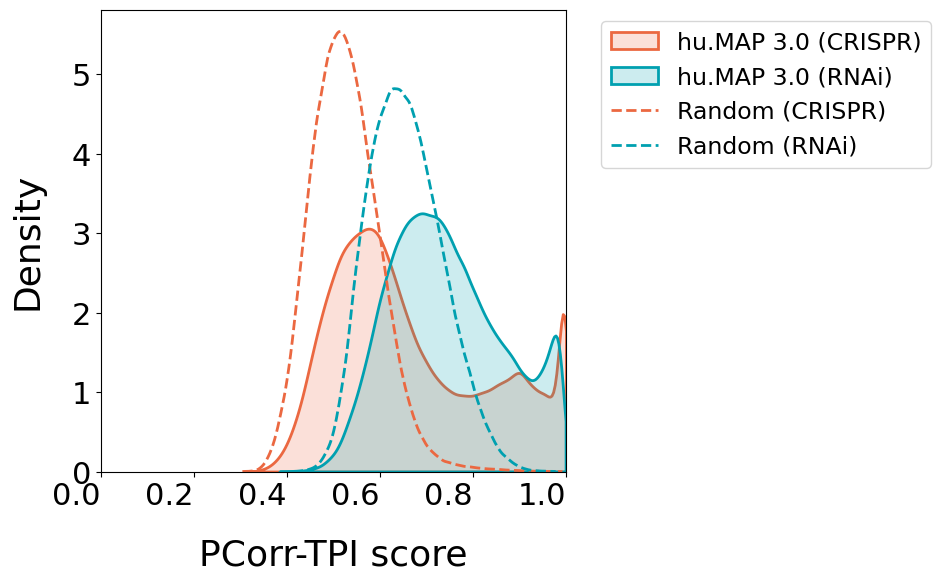

In [21]:
r_humap_key = pickle.load(open('PCorr_TPI_datasets/r_humap_key.pkl', 'rb'))
r_randomhumap_key = pickle.load(open('PCorr_TPI_datasets/r_randomhumap_key.pkl', 'rb'))

plt.figure(figsize=(6, 6))

r = r_humap_key['CRISPR']
r['score'] = np.mean(r, axis=1)
sns.kdeplot(r['score'], cut=0, fill=True, color='#eb6841',
            alpha=0.2, linewidth=2,label='hu.MAP 3.0 (CRISPR)')

r = r_humap_key['RNAi']
r['score'] = np.mean(r, axis=1)
sns.kdeplot(r['score'], cut=0, fill=True, color='#00a0b0',
            alpha=0.2, linewidth=2,label='hu.MAP 3.0 (RNAi)')

r = r_randomhumap_key['CRISPR']
r['score'] = np.mean(r, axis=1)
sns.kdeplot(r['score'], cut=0, fill=False, color='#eb6841',ls='--',
            alpha=1, linewidth=2,label='Random (CRISPR)')

r = r_randomhumap_key['RNAi']
r['score'] = np.mean(r, axis=1)
sns.kdeplot(r['score'], cut=0, fill=False, color='#00a0b0',ls='--',
            alpha=1, linewidth=2,label='Random (RNAi)')

plt.yticks(ha='right', fontsize=22)
plt.xticks(ha='right', fontsize=22, rotation=0)
plt.xlabel('PCorr-TPI score', fontsize=26, labelpad=20)
plt.ylabel('Density', fontsize=26, labelpad=20)
plt.xlim(0, 1)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=17, markerfirst=True,
           markerscale=1, scatterpoints=1, ncol=1, title_fontsize=17)
plt.show()

##### 5. Relationships between PCorr signals and confidence levels of protein complexes from huMAP3

In [13]:
r_humap_key = pickle.load(open('PCorr_TPI_datasets/r_humap_key.pkl', 'rb'))

# 1
r_id_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    r_all = r_humap_key[ge_key].copy()
    r_all['score'] = r_all.mean(axis=1)
    r_index_set = set(r_all.index)

    r_id = {}
    for i in tqdm(tpi_id.keys()):
        tpis = tpi_id[i]
        t_overlap = r_index_set.intersection(tpis)
        if t_overlap:
            scores = r_all.loc[list(t_overlap), 'score']
            r_id[i] = scores
    r_id_key[ge_key] = r_id

# 2
fr_id_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    fr_id = {}
    r_id = r_id_key[ge_key]

    for i in tqdm(r_id):
        r = r_id[i]
        tpis = tpi_id[i]
        
        genes = {g for t in tpis for g in t}
        tpis_r = r.index
        genes_r = {g for t in tpis_r for g in t}

        if genes != genes_r:
            continue
        edges = set()
        for t in tpis_r:
            edges.update(itertools.combinations(t, 2))

        G = nx.from_edgelist(edges)

        if nx.is_connected(G):
            fr_id[i] = r.mean()
    fr_id_key[ge_key] = fr_id

# 3
ids_c = set(fr_id_key['CRISPR'].keys())
ids_r = set(fr_id_key['RNAi'].keys())
ids_all = ids_c | ids_r

result = pd.DataFrame()
for i in tqdm(ids_all):
    result.loc[i, 'confidence'] = db.loc[i, 'ComplexConfidence']

    result.loc[i,'genes'] = db.loc[i,'genenames']
    result.loc[i,'tpis'] = '|'.join([';'.join(list(j)) for j in tpi_id[i]])
    result.loc[i, 'tpis_num'] = len(tpi_id[i])
    if i in ids_c:
        fr = fr_id_key['CRISPR'][i]
        result.loc[i, 'score_CRISPR'] = fr
        result.loc[i, 'tpis_CRISPR'] = '|'.join([';'.join(list(j)) for j in r_id_key['CRISPR'][i].index])
        result.loc[i, 'tpis_score_CRISPR'] = '|'.join(list(r_id_key['CRISPR'][i].astype('str')))
        result.loc[i, 'tpis_num_CRISPR'] = len(r_id_key['CRISPR'][i])

    if i in ids_r:
        fr = fr_id_key['RNAi'][i]
        result.loc[i, 'score_RNAi'] = fr
        result.loc[i, 'tpis_RNAi'] = '|'.join([';'.join(list(j)) for j in r_id_key['RNAi'][i].index])
        result.loc[i, 'tpis_score_RNAi'] = '|'.join(list(r_id_key['RNAi'][i].astype('str')))
        result.loc[i, 'tpis_num_RNAi'] = len(r_id_key['RNAi'][i])

100%|██████████| 2017/2017 [00:04<00:00, 473.48it/s]


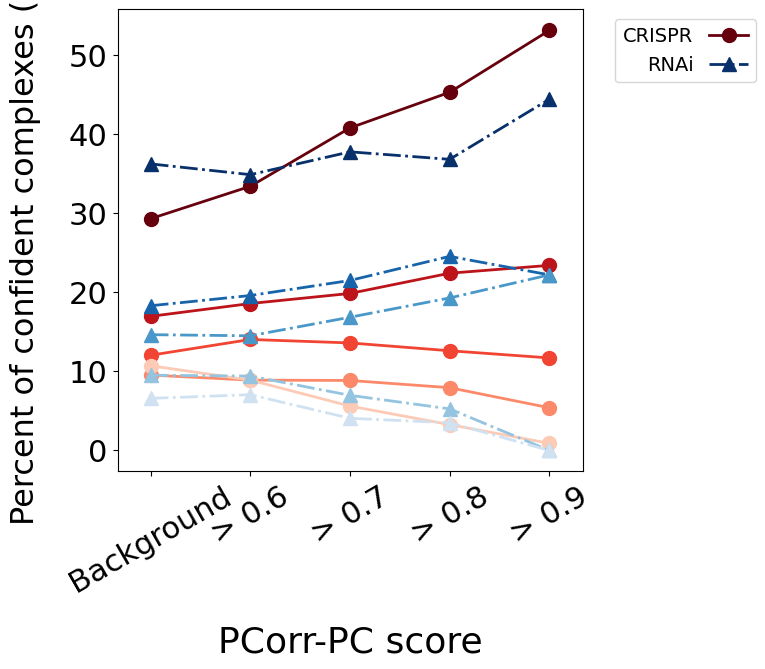

In [16]:
scores = [0,0.6,0.7,0.8,0.9]

y_key = {}
for ge_key in ['CRISPR','RNAi']:
    y = []
    for conf in range(1,6):
        y_ = []
        for score in scores:
            r_all = result[(result['score_{}'.format(ge_key)].isna() == False) &
                       (result['score_{}'.format(ge_key)] > score)]

            r = result[(result['score_{}'.format(ge_key)].isna() == False) &
                       (result['score_{}'.format(ge_key)] > score) &
                       (result['confidence'] == conf)]

            y_.append(len(r)/len(r_all)*100)
        y.append(y_)
    y_key[ge_key] = y

x = np.arange(0,3*len(scores),3)

score_info = ['Background']+['> {}'.format(i) for i in scores[1:]]


fig, ax=plt.subplots(figsize=(6, 6))

y = y_key['CRISPR']
cmap = get_cmap("Reds_r")
colors = [cmap(i) for i in np.linspace(0, 0.8, 5)]

plt.plot(x, y[0],lw=2,marker='o',ls='-', ms=10, c=colors[0],label='CRISPR')
plt.plot(x, y[1],lw=2,marker='o',ls='-', ms=10, c=colors[1])
plt.plot(x, y[2],lw=2,marker='o',ls='-', ms=10, c=colors[2])
plt.plot(x, y[3],lw=2,marker='o',ls='-', ms=10, c=colors[3])
plt.plot(x, y[4],lw=2,marker='o',ls='-', ms=10, c=colors[4])

y = y_key['RNAi']
cmap = get_cmap("Blues_r")
colors = [cmap(i) for i in np.linspace(0, 0.8, 5)]

plt.plot(x, y[0],lw=2,marker='^',ls='-.', ms=10, c=colors[0],label='RNAi')
plt.plot(x, y[1],lw=2,marker='^',ls='-.', ms=10, c=colors[1])
plt.plot(x, y[2],lw=2,marker='^',ls='-.', ms=10, c=colors[2])
plt.plot(x, y[3],lw=2,marker='^',ls='-.', ms=10, c=colors[3])
plt.plot(x, y[4],lw=2,marker='^',ls='-.', ms=10, c=colors[4])

plt.xticks(x,score_info,fontsize=22,rotation=30)
plt.yticks(fontsize=22)
plt.ylabel('Percent of confident complexes (%)',fontsize=23,labelpad=20)
plt.xlabel('PCorr-PC score',fontsize=26,labelpad=20)
plt.xlim(-1,len(scores)*3-2)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),fontsize=14,markerfirst=False,
           markerscale=1,scatterpoints=1,ncol=1,title_fontsize=17)
plt.show()

##### 6. Percentage of hu.MAP 3.0 complexes retained at various PCorr-PC score thresholds

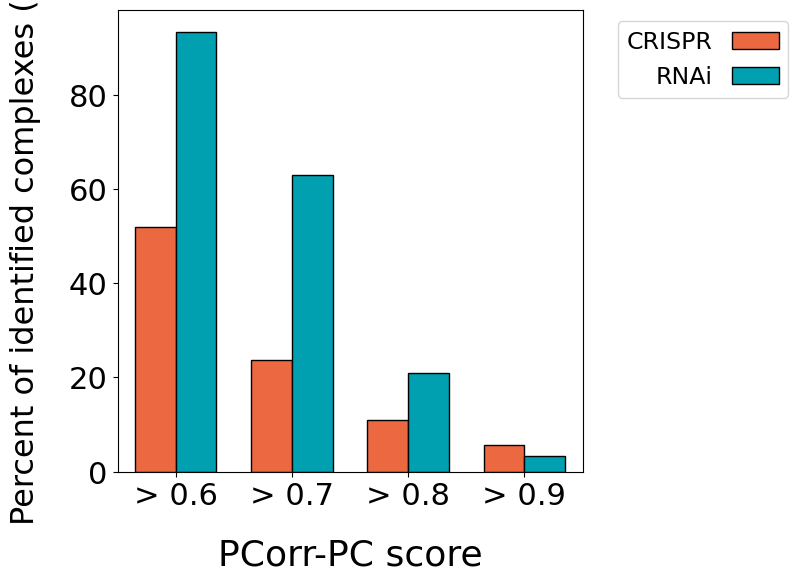

In [17]:
scores = [0.6,0.7,0.8,0.9]

y = []
for ge_key in ['CRISPR','RNAi']:
    y_ = []
    for score in scores:
        r_bg = result[result['score_{}'.format(ge_key)].isna() == False]
        r = result[(result['score_{}'.format(ge_key)].isna() == False) &
                   (result['score_{}'.format(ge_key)] > score)]
        y_.append(len(r)/len(r_bg)*100)
    y.append(y_)

x = np.arange(0,2*len(scores),2)

width=0.7
x1 = x-width/2
x2 = x+width/2

score_info = ['> {}'.format(i) for i in scores]

fig, ax=plt.subplots(figsize=(6, 6))
plt.bar(x1, y[0],facecolor='#eb6841',lw=1,width=0.7,label= 'CRISPR',edgecolor='black')
plt.bar(x2, y[1],facecolor='#00a0b0',lw=1,width=0.7,label='RNAi',edgecolor='black')

plt.xticks(x,score_info,fontsize=22,rotation=0)
plt.yticks(fontsize=22)
plt.ylabel('Percent of identified complexes (%)',fontsize=23,labelpad=20)
plt.xlabel('PCorr-PC score',fontsize=26,labelpad=20)
plt.xlim(-1,len(scores)*2-1)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),fontsize=17,markerfirst=False,
           markerscale=1,scatterpoints=1,ncol=1,title_fontsize=17)
plt.show()